# Import Library

In [ ]:
pip install --upgrade tensorflow keras

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/train'

test_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/test'

val_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/validation'

In [6]:
from collections import Counter

def check_distribution(dir_path):
    class_counts = Counter()
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Distribusi data di folder train:", check_distribution(train_dir))
print("Distribusi data di folder validation:", check_distribution(val_dir))
print("Distribusi data di folder test baru:", check_distribution(test_dir))

Distribusi data di folder train: Counter({'Square': 799, 'Heart': 798, 'Oblong': 798, 'Oval': 797, 'Round': 789})
Distribusi data di folder validation: Counter({'Heart': 100, 'Oblong': 100, 'Square': 100, 'Round': 99, 'Oval': 99})
Distribusi data di folder test baru: Counter({'Round': 100, 'Heart': 100, 'Oval': 100, 'Oblong': 100, 'Square': 100})


In [7]:
class_names = ['Oblong', 'Heart', 'Round', 'Square', 'Oval']

In [8]:
def create_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=True
    )

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    return train_ds, validation_ds, test_ds

In [9]:
# Create datasets with or without data augmentation
train_ds, validation_ds, test_ds = create_datasets()

Found 3981 files belonging to 5 classes.
Found 498 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [10]:
# from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (224, 224, 3)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

tuning_layer_name = 'block_14_expand'
tuning_layer = base_model.get_layer(tuning_layer_name)
tuning_index = base_model.layers.index(tuning_layer)

# Membekukan semua layer sebelum tuning_layer
for layer in base_model.layers[:tuning_index]:
    layer.trainable = False


# base_model = VGG16(input_shape=IMG_SHAPE,
#                    include_top=False,
#                    weights='imagenet')

# for layer in base_model.layers:
#   layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

In [37]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dropout(0.3),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 1,855,301 (7.08 MB)

 Non-trainable params: 731,904 (2.79 MB)

In [38]:
learning_rate = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>1.0:
            self.model.stop_training = True
            print("\nReached 100% accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

In [39]:
history = model.fit(
    train_ds,
    epochs=70,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[early_stopping_callback]
)

Epoch 1/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 160ms/step - accuracy: 0.7893 - loss: 4.6330 - val_accuracy: 0.7470 - val_loss: 4.2341
Epoch 2/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.9705 - loss: 3.2161 - val_accuracy: 0.7269 - val_loss: 3.7328
Epoch 3/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9700 - loss: 2.5214 - val_accuracy: 0.6928 - val_loss: 3.3790
Epoch 4/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.9679 - loss: 2.0276 - val_accuracy: 0.7269 - val_loss: 2.8065
Epoch 5/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.9736 - loss: 1.6543 - val_accuracy: 0.7349 - val_loss: 2.5490
Epoch 6/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - accuracy: 0.9740 - loss: 1.3734 - val_accuracy: 0.7269 - val_loss: 2.3742
Epoch 7/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.9741 - loss: 1.1501 - val_accuracy: 0.7470 - val_loss: 2.0604
Epoch 8/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.9645 - loss: 1

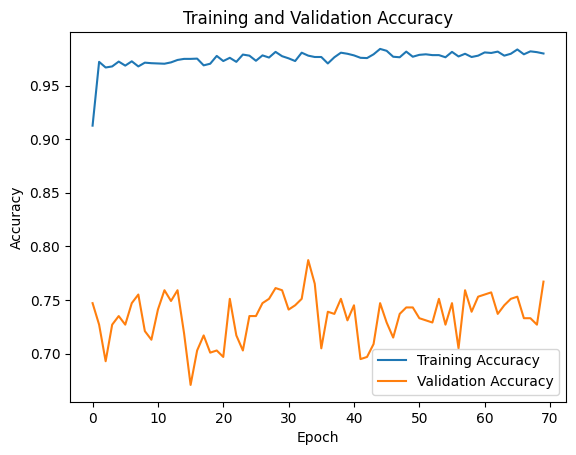

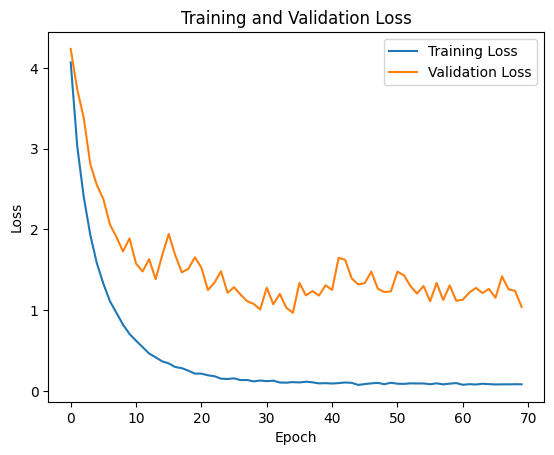

In [47]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [41]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# test_dir2 = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test'

# test_ds

# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# You can print the metrics:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step
Accuracy: 0.79
Precision: 0.7975146414875848
Recall: 0.79
F1 Score: 0.7899080059294638


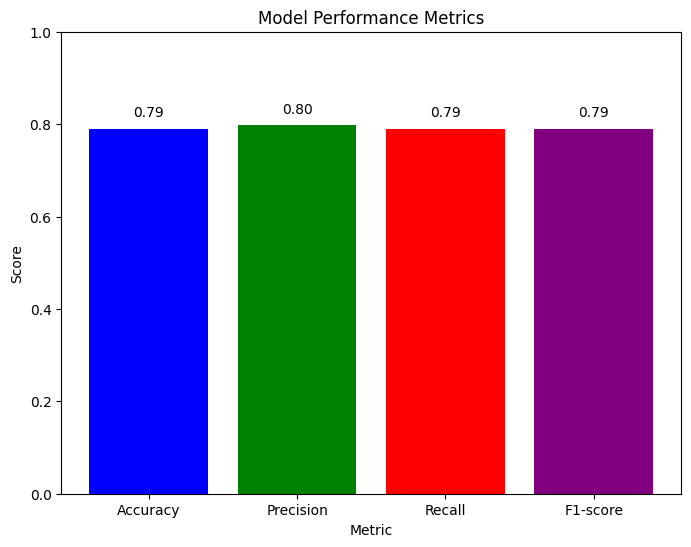

In [42]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

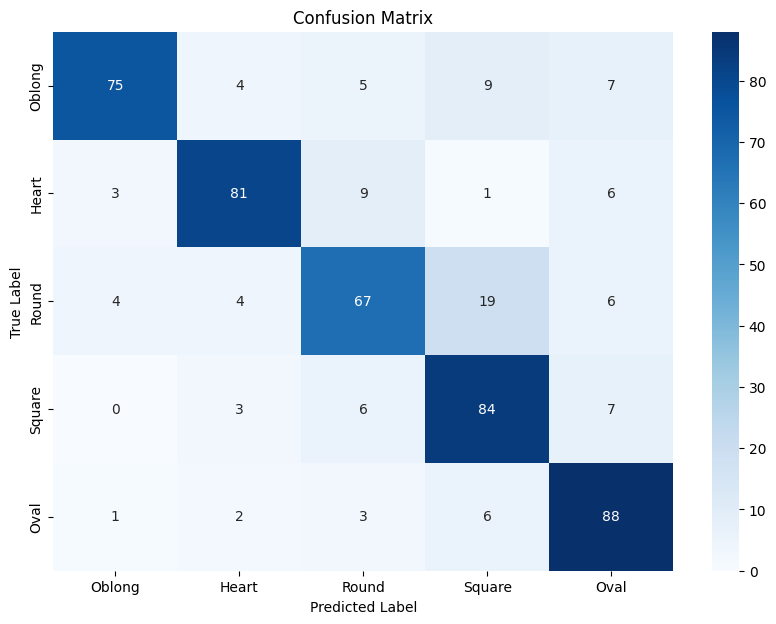

In [43]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [44]:
model.save('/content/drive/MyDrive/Model/Model_V4.h5')

In [45]:
model_path = '/content/drive/MyDrive/Model/Model_V4.keras'
tf.keras.models.save_model(
    model, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None)

## Convert to tfLite

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Model/Model_V4.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpt_eitz3j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_206')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139380687396656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380730575184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709151440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709156896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709157952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709152144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709364608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709367248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709363200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139380709365136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393807091